In [1]:
import torch
from torch import nn


class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, h_dim=200, z_dim=20):
        super().__init__()
        # encoder
        self.img_2hid = nn.Linear(input_dim, h_dim)
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)

        # decoder
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.hid_2img = nn.Linear(h_dim, input_dim)

        self.relu = nn.ReLU()

    def encode(self, x):
        h = self.relu(self.img_2hid(x))
        mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
        return mu, sigma

    def decode(self, z):
        h = self.relu(self.z_2hid(z))
        return torch.sigmoid(self.hid_2img(h))

    def forward(self, x):
        mu, sigma = self.encode(x)
        # reparametrization trick
        epsilon = torch.randn_like(sigma)
        z_new = mu + sigma*epsilon
        x_reconstructed = self.decode(z_new)
        return x_reconstructed, mu, sigma


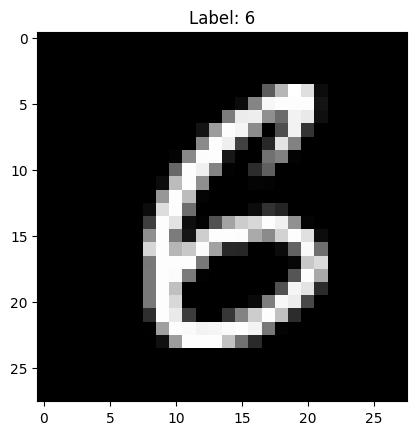

In [11]:
import torch
import torchvision.datasets as datasets  # Standard datasets
from tqdm import tqdm
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 784
H_DIM = 200
Z_DIM = 20
NUM_EPOCHS = 30
BATCH_SIZE = 32
LR_RATE = 3e-4  # Karpathy constant

# Dataset Loading
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
model = VariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.BCELoss(reduction="sum")

# Choose a batch of images
data_iterator = iter(train_loader)
images, labels = next(data_iterator)

# Display the first image from the batch
image = images[0].squeeze().numpy()  # Squeeze to remove the channel dimension and convert to a NumPy array
plt.imshow(image, cmap='gray')
plt.title(f"Label: {labels[0]}")
plt.show()

In [12]:
# Training
for epoch in range(NUM_EPOCHS):
    loop = tqdm(enumerate(train_loader))
    for i, (x, _) in loop:
        # forward pass
        x = x.to(DEVICE).view(x.shape[0], INPUT_DIM)
        x_reconstructed, mu, sigma = model(x)

        # compute loss
        reconstruction_loss = loss_fn(x_reconstructed, x)
        kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

        # backprop
        loss = reconstruction_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())

1875it [00:08, 226.74it/s, loss=5.26e+3]
1875it [00:08, 226.97it/s, loss=4.64e+3]
1875it [00:07, 242.16it/s, loss=4.18e+3]
1875it [00:07, 238.70it/s, loss=4.01e+3]
1875it [00:08, 232.63it/s, loss=4.1e+3] 
1875it [00:08, 234.16it/s, loss=4.34e+3]
1875it [00:07, 239.97it/s, loss=4.46e+3]
1875it [00:07, 238.02it/s, loss=3.97e+3]
1875it [00:08, 230.87it/s, loss=3.91e+3]
1875it [00:07, 239.06it/s, loss=4.06e+3]
1875it [00:07, 242.09it/s, loss=4.13e+3]
1875it [00:07, 243.97it/s, loss=4.15e+3]
1875it [00:07, 243.68it/s, loss=4.23e+3]
1875it [00:07, 245.15it/s, loss=3.91e+3]
1875it [00:07, 243.48it/s, loss=4.08e+3]
1875it [00:07, 243.69it/s, loss=4.32e+3]
1875it [00:07, 242.82it/s, loss=4.04e+3]
1875it [00:08, 229.34it/s, loss=4.07e+3]
1875it [00:08, 233.10it/s, loss=4.22e+3]
1875it [00:07, 242.00it/s, loss=4.07e+3]
1875it [00:07, 243.41it/s, loss=3.69e+3]
1875it [00:08, 231.45it/s, loss=4.38e+3]
1875it [00:07, 242.84it/s, loss=4.25e+3]
1875it [00:07, 245.57it/s, loss=4.09e+3]
1875it [00:07, 2

In [21]:
def inference_all(num_examples=1):
    """
    Generates (num_examples) of a particular digit.
    Specifically we extract an example of each digit,
    then after we have the mu, sigma representation for
    each digit we can sample from that.

    After we sample we can run the decoder part of the VAE
    and generate examples.
    """
    images = []
    idx = 0
    # save one image for each label
    for x, y in dataset:
        if y == idx:
            images.append(x)
            idx += 1
        if idx == 10:
            break

    # encode each image
    encodings_digit = []
    for d in range(10):
        with torch.no_grad():
            mu, sigma = model.encode(images[d].view(1, 784))
        encodings_digit.append((mu, sigma))

    for digit in range(10):
        mu, sigma = encodings_digit[digit]
        for example in range(num_examples):
            epsilon = torch.randn_like(sigma)
            z = mu + sigma * epsilon
            out = model.decode(z)
            out = out.view(-1, 1, 28, 28)
            save_image(out, f"output/MNIST/generated_{digit}_ex{example}.png")
    
    return images, encodings_digit


images, encodings_digit = inference_all(num_examples=2)